In [2]:
import numpy as np
import cv2 as cv
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
import os


filenames_all = glob.glob("/root/CelebAMask-HQ/CelebA-HQ-img/*")
filenames = []

#we delete names of images for witch we don't have hair masks
for filename in filenames_all:
    num = filename.split("/")[-1].split(".")[0]
    folder = int(num) // 2000
    filepath = "/root/CelebAMask-HQ/CelebAMask-HQ-mask-anno/" + str(folder) + "/" + "0" * (5 - len(num)) + str(num) + "_hair.png"
    if os.path.exists(filepath):
        filenames.append(filename)

In [4]:
def get_image_and_mask(filenum, size=(256, 256)):
    """
    filenum: num of element in filenames list
    size: size of resized images
    returns: Image and hair mask from image, resized to given size
    """
    num = filenames[filenum].split("/")[-1].split(".")[0]
    folder = int(num) // 2000
    maskpath = "/root/CelebAMask-HQ/CelebAMask-HQ-mask-anno/" + str(folder) + "/" + "0" * (5 - len(num)) + str(num) + "_hair.png"
    
    image = cv.resize(plt.imread(filenames[filenum]), size)
    mask = cv.resize(plt.imread(maskpath), size)
    return image, mask[:,:,0]

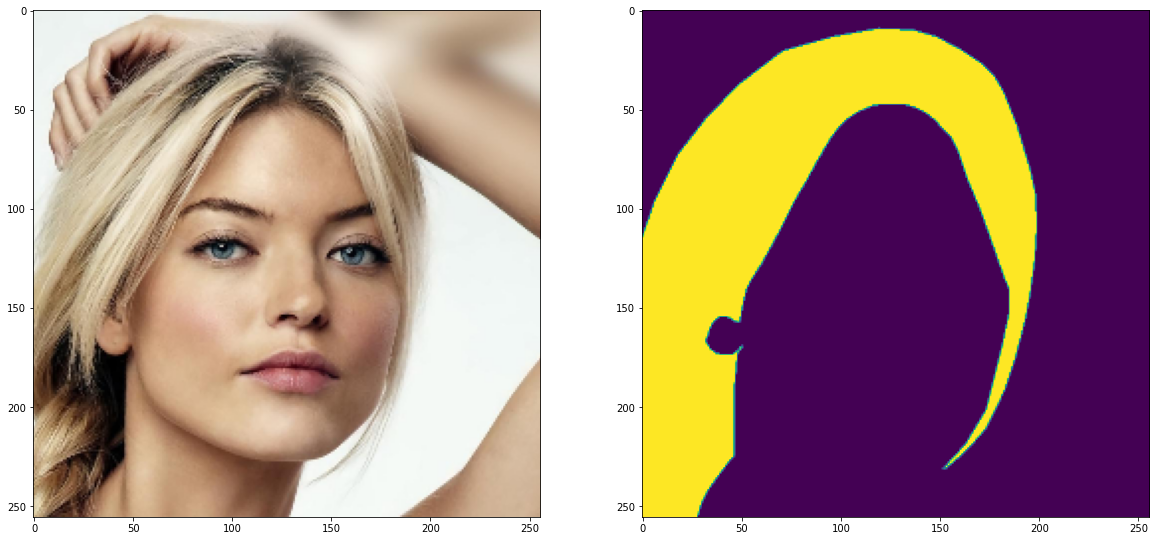

In [5]:
#let's show an example of how it works
img, mask = get_image_and_mask(0)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img)
ax[1].imshow(mask)

In [6]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.heatmaps import HeatmapsOnImage
from torchvision import transforms

#we use imgaug to augment images and masks.

#Here we define transformations we apply to images and masks on training stage
seq = iaa.Sequential([
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Dropout([0.01, 0.05],),
    iaa.Sharpen((0.0, 1.0)),
    iaa.Affine(rotate=(-10, 10)),
    iaa.ElasticTransformation(alpha=2, sigma=1.5)
], random_order=True)

blank_seq = seq = iaa.Sequential([])


In [7]:
#here we define CelebDataset as torch dataset with images and masks
class CelebDatset(Dataset):
    def __init__(self, left, right, seq=seq):
        self.fontFile = "HomepageBaukasten-Book.ttf"
        self.left= left
        self.right = right
        self.transform = seq
    
    def __len__(self):
        return self.right - self.left
    
    def __getitem__(self, idx):

        pimg, nmask = get_image_and_mask(self.left + idx)
        depth = HeatmapsOnImage(
            nmask.astype(np.float32), shape= nmask.shape, min_value=0.0, max_value=1.0)

        transformed = seq(images=np.array(pimg)[None].astype(np.uint8), heatmaps=depth)
        target = {}
        target["masks"] =  torch.Tensor(transformed[1].get_arr())

        return transforms.ToTensor()(transformed[0][0]), target
    
dataset = CelebDatset(50, 100)

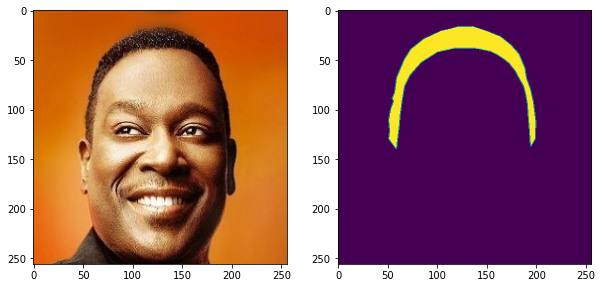

In [8]:
#example of dataset usage
img, trg = dataset[100]
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(img.permute(1, 2, 0).numpy())
ax[1].imshow(trg["masks"])

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Here we define Classical U-net model, taken from https://github.com/milesial/Pytorch-UNet
#For easier usage, we copy functions we need to create model

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ) 

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 384)
        factor = 2 if bilinear else 1
        self.up2 = Up(640, 256, bilinear)
        self.up3 = Up(384, 128, bilinear)
        self.up4 = Up(192, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = nn.Sigmoid()(self.outc(x))
        sqzd = torch.squeeze(logits, 1)
        return sqzd


In [10]:
from torchsummary import summary
net = UNet(3, 1)
summary(net.cuda(), (3, 100, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 200]           1,792
       BatchNorm2d-2         [-1, 64, 100, 200]             128
              ReLU-3         [-1, 64, 100, 200]               0
            Conv2d-4         [-1, 64, 100, 200]          36,928
       BatchNorm2d-5         [-1, 64, 100, 200]             128
              ReLU-6         [-1, 64, 100, 200]               0
        DoubleConv-7         [-1, 64, 100, 200]               0
         MaxPool2d-8          [-1, 64, 50, 100]               0
            Conv2d-9         [-1, 128, 50, 100]          73,856
      BatchNorm2d-10         [-1, 128, 50, 100]             256
             ReLU-11         [-1, 128, 50, 100]               0
           Conv2d-12         [-1, 128, 50, 100]         147,584
      BatchNorm2d-13         [-1, 128, 50, 100]             256
             ReLU-14         [-1, 128, 

In [11]:
#Here we create Dice Loss we will optimize during training
class MyDice(nn.Module):
    def __init__(self) -> None:
        super(MyDice, self).__init__()
        self.eps: float = 1e-6

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:

        dims = (1, 2)
        intersection = torch.sum(input * target, dims)
        cardinality = torch.sum(input + target, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        return torch.mean(1. - dice_score)

In [12]:

#This is linear combination of dice loss and BCE loss
class BceDice(nn.Module):
    def __init__(self, p = 0.7) -> None:
        super(BceDice, self).__init__()
        self.p = p
    
    def forward(self,
            input: torch.Tensor,
            target: torch.Tensor):
        return self.p  * MyDice()(input, target) + (1 - self.p) * F.binary_cross_entropy_with_logits(torch.unsqueeze(input, 1).float(), torch.unsqueeze(target, 1).float())


In [13]:
def eval_net(net, loader, device):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    n_val = len(loader)  # the number of batch
    tot = 0
    print(n_val)
    with tqdm(total=n_val, desc='Validation round', unit='batch',position=0, leave=True) as pbar:
        for batch in loader:
            imgs, true_masks = batch[0], batch[1]['masks']
            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=mask_type)

            with torch.no_grad():
                mask_pred = net(imgs)

            if net.n_classes > 1:
                tot += F.cross_entropy(mask_pred, true_masks).item()
            else:
                pred = torch.sigmoid(mask_pred)
                pred = (pred > 0.5).float()
                tot += MyDice()(pred, true_masks)
            pbar.update()

    net.train()
    return tot / n_val

In [14]:
#here we create datasets and dataloaders for trining and validation

dataset = CelebDatset(0, len(filenames) - 1000)
loader = DataLoader(dataset, batch_size=6, shuffle=False, num_workers=1)

val_dataset = CelebDatset(len(filenames) - 1000, len(filenames) - 1)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

In [17]:
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

lr = 0.001
batch_size = 8
img_scale = 1
writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
global_step = 0

epochs = 10
n_train = 1000
device = torch.device("cuda")
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

criterion = MyDice()
# criterion = BceDice()
#and now we train the network!
for epoch in range(epochs):
    net.train()

    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img', position=0, leave=True) as pbar:
        if (global_step  >= 3000):
                criterion = MyDice()
        for batch in loader:
           
            imgs = batch[0]
            true_masks = batch[1]['masks']
            assert imgs.shape[1] == net.n_channels, \
                f'Network has been defined with {net.n_channels} input channels, ' \
                f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                'the images are loaded correctly.'

            imgs = imgs.to(device=device, dtype=torch.float32)
            mask_type = torch.float32 if net.n_classes == 1 else torch.long
            true_masks = true_masks.to(device=device, dtype=mask_type)

            masks_pred = net(imgs)
            loss = criterion( masks_pred, true_masks)
            epoch_loss += loss.item()

            pbar.set_postfix(**{'loss (batch)': loss.item()})

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()

            pbar.update(imgs.shape[0])
            global_step += 1
            if global_step % (3000) == 0:
                for tag, value in net.named_parameters():
                    tag = tag.replace('.', '/')

                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)



Epoch 1/10: 1860img [00:52, 35.74img/s, loss (batch)=0.125]                         


KeyboardInterrupt: 

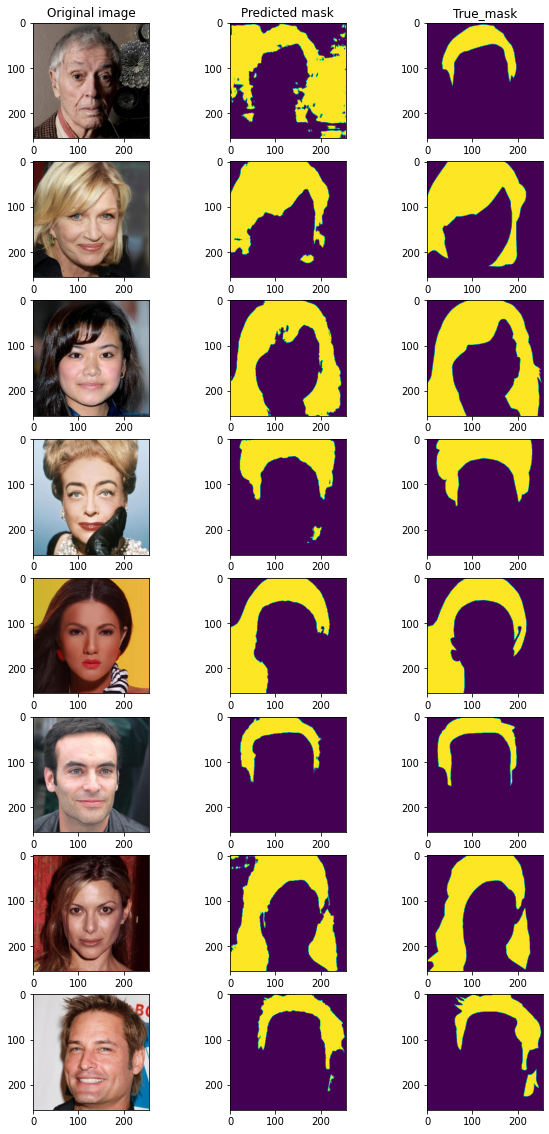

In [18]:
import time

#lets see some results
#we will take one butch from validation loader and look at results on it
imten = next(iter(val_loader))
fig, ax = plt.subplots(len(imten[0]), 3, figsize = (10, 20))
for i in range(len(imten[0])):
    
    image = imten[0][i]
    target = imten[1]["masks"][i]
    ax[i][0].imshow(image.permute(1, 2, 0).numpy())
    net.eval()
    
    start_time = time.time()
    ax[i][1].imshow(net.cuda()((torch.unsqueeze(image.cuda(), 0))).cpu().detach().numpy()[0])
    end_time = time.time()
    ax[i][2].imshow(target.numpy())
    
ax[0][0].set_title("Original image")
ax[0][1].set_title("Predicted mask")
ax[0][2].set_title("True_mask")
plt.show()